In [1]:
%load_ext autoreload

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Enron dataset for GPT-2

Here, we aim to fine-tune GPT-2 on the famous Enron email dataset.

## Data cleaning

In [2]:
## Convert the CSV file from https://data.world/brianray/enron-email-dataset to pickle using
# pd.read_csv('enron_05_17_2015_with_labels_v2.csv', low_memory=False)\
#   .to_pickle('enron_05_17_2015_with_labels_v2.lfs.pkl.bz2')

data_raw = pd.read_pickle('./data/enron_05_17_2015_with_labels_v2.lfs.pkl.bz2')

In [3]:
data = data_raw.copy()
print('{} rows in Raw Data'.format(data.shape[0]))

data = data.drop_duplicates('content')
print('{} rows after dropping duplicates'.format(data.shape[0]))

data = data[(data.Subject != np.nan)
            & (data.Subject.str.len() > 0)
            & ~(data.content.str.startswith('--', na=False))
            & ~(data.content.str.startswith('__', na=False))
            & ~(data.content.str.startswith('<', na=False))
            & ~(data.content.str.contains('LOG MESSAGES', na=False))
            & ~(data.content.str.contains('Content-Type:', na=False))
           ]
print('{} rows after shallow filtering'.format(data.shape[0]))


517401 rows in Raw Data
241860 rows after dropping duplicates
210111 rows after shallow filtering


In [4]:
import re

import parmap
import spacy

%autoreload
import EFZP as zp

import re

import parmap
import spacy

%autoreload
import EFZP as zp

nlp = spacy.load("en_core_web_sm")

# For testing
# data = data.sample(100, random_state=42)
# display(data)

regexp_email = r"(<?[\w\.=-]+@[\w\.-]+\.[\w]{2,3})"
regexp_date = r"([0]?\d|[1][0-2])\/([0-2]?\d|[3][0-1])\/([2][01]|[1][6-9])(\d{2})?(\s([0-1]?\d|[2][0-3])(\:[0-5]?\d){1,2})"

relative_date_terms = ['day', 'week', 'year', 'tomorrow', 'month', 'tommorrow', 'daily', 'quarter', 'decade', 'summer', 'winter', 'fall', 'spring']

def replace_named_entities(text):
    """Replace tokens in text"""
    doc = nlp(text)
    for entity in doc.ents:
        if entity.label_ in ['PERSON', 'ORG', 'GPE']:
            text = text.replace(entity.text, "<|{}|>".format(entity.label_))
        
        # Keep relative dates
        if (entity.label_ == 'DATE') and not any([x in entity.text.lower() for x in relative_date_terms]):
            text = text.replace(entity.text, "<|{}|>".format(entity.label_))
    return text.strip()

def remove_prefix_postfix(text, searchstr):
    expr = r'(^{token})|({token}$)'.format(token=re.escape(searchstr))
    return re.sub(expr, '', text.strip())

def clean_text(args):
    (index, row) = args
    parsed = zp.parse(str(row.content), remove_quoted_statements=False)
    
    for key, value in parsed.items():
        row[key] = value
    
    text = row['body'] 
    
    # Cut string at known substrings
    for stopstr in ['---', '__', 'from:', 'to:', '[image]', '===']:
        cutoff = text.lower().find(stopstr)
        if cutoff >= 0:
            text = text[:cutoff]
    
    # Cut string at known regexp
    for stopexp in [regexp_email, regexp_date]:
        match = re.search(stopexp, text)
        if match:
            text = text[:match.start()]
            
    # Replace repeated chars [., ?, !] and control chars
    for (subexp, replace) in [
        (r'\.{4,}', '...'),
        (r'\?{2,}', '?'),
        (r'\!{2,}', '!'),
        (r'\=(\s|\d{2})', '')
    ]:
        text = re.compile(subexp).sub(replace, text)
    
    text = replace_named_entities(text)
    text = remove_prefix_postfix(text, '<|PERSON|>')
    row['body_cleaned'] = text.strip()
    return row

data = pd.DataFrame(parmap.map(clean_text, list(data.iterrows()), pm_pbar=True))


210112it [20:52, 167.73it/s]                            


In [5]:
# data.body_cleaned.to_csv('body_cleaned.txt', index=False)
# data.body.to_csv('body.txt', index=False)

In [6]:
data.to_pickle('data/enron_05_17_2015_preprocessed.lfs.pkl.bz2')

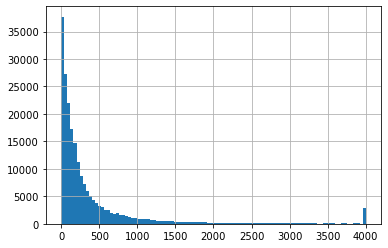

In [7]:
import matplotlib.pyplot as plt


data.body_cleaned.str.len().clip(upper=4000).hist(bins=100)
plt.show()

In [8]:
print('{} rows before filtering'.format(data.shape[0]))

data_filtered = data[(data.body_cleaned.str.len() >= 250)
                     & (data.body_cleaned.str.len() <= 1500)
                     & data.From.str.contains('enron', na=False)
                     & ~data.From.str.contains('exchange.administrator@enron.com', na=False)
                     & ~data.From.str.contains('arsystem@mailman.enron.com', na=False)
                     & ~data.From.str.contains('critical.notice@enron.com', na=False)      
                     & ~data.From.str.contains('perfmgmt@enron.com', na=False)
                     & ~data.From.str.contains('cms.router@enron.com', na=False)
                     & ~data.body_cleaned.str.startswith('CALENDAR ENTRY:')
                     & ~data.body_cleaned.str.startswith('W E E K E N D S Y S T E M S A V A I L A B I L I T Y')
                     & ~data.body_cleaned.str.startswith('PROCESSING')
                     & ~data.body_cleaned.str.contains('SAME DAY DR TRANSFER', na=False)
                     & ~data.body_cleaned.str.contains('dial-in number', na=False)
                     & ~data.body_cleaned.str.contains('Passcode', na=False)
                     & ~data.body_cleaned.str.contains('http://', na=False)
                     & ~data.body_cleaned.str.contains('https://', na=False)
                     & ~data.body_cleaned.str.contains('FYI', case=False, na=False)
                     & ~data.body_cleaned.str.contains('please click here', case=False, na=False)
                     & ~data.body_cleaned.str.contains('subscribe', case=False, na=False)
                     & ~data.body_cleaned.str.contains('newsletter', case=False, na=False)]

data_filtered = data_filtered.sample(frac=1, random_state=42)

data_filtered.to_pickle('data/enron_05_17_2015_preprocessed_filtered.lfs.pkl.bz2')

print('{} rows after filtering'.format(data_filtered.shape[0]))


210111 rows before filtering
44806 rows after filtering


In [9]:
def write_to_file(df, filename):
    with open(filename, 'w') as the_file:
        for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
            the_file.write('<|endoftext|>{}<|SEP|>{}<|endoftext|>\n'.format(row.Subject, 
                                                                          row.body_cleaned))

train, test = np.split(data_filtered, [int(.8 * data_filtered.shape[0])])

write_to_file(train, './sagemaker/fine_tuning/train.lfs.txt')
write_to_file(test, './sagemaker/fine_tuning/test.lfs.txt')

write_to_file(train.sample(100, random_state=42), './sagemaker/fine_tuning/train.sample.lfs.txt')
write_to_file(test.sample(20, random_state=42), './sagemaker/fine_tuning/test.sample.lfs.txt')
